## Chargement et exploration des donnees

In [1]:
# Importation des bibliothèques
import pandas as pd

# Charger les données
df = pd.read_csv('spam_ham_dataset.csv')  # Remplace 'dataset.csv' par le chemin correct

# Afficher un aperçu des données
print(df.head())

# Vérifier les classes
print(df['label'].value_counts())

# Afficher les statistiques générales
print(df.info())


   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  
label
ham     3672
spam    1499
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None


## Étape 2 : Prétraitement du Texte
Nettoyage :
- Convertir le texte en minuscule
- Retirer les stopwords
- Enlever la ponctuation, les chiffres
- Tokeniser le texte

In [2]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Fonction de prétraitement
def preprocess_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r'\d+', '', text)  # Retirer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Retirer la ponctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Stopwords
    return ' '.join(words)

# Appliquer le nettoyage
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Afficher un aperçu
print(df[['text', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taouc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  Subject: enron methanol ; meter # : 988291\r\n...   
1  Subject: hpl nom for january 9 , 2001\r\n( see...   
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3  Subject: photoshop , windows , office . cheap ...   
4  Subject: re : indian springs\r\nthis deal is t...   

                                        cleaned_text  
0  subject enron methanol meter follow note gave ...  
1  subject hpl nom january see attached file hpln...  
2  subject neon retreat ho ho ho around wonderful...  
3  subject photoshop windows office cheap main tr...  
4  subject indian springs deal book teco pvr reve...  


## Étape 3 : Vectorisation des Textes
Tester différentes techniques : 
- BoW
- TF-IDF
- Word2Vec
- Doc2Vec.

#### BOW et Tf-Idf

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialiser les vectoriseurs
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Transformer les textes
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Labels
y = df['label_num']


### Word2Vec

In [4]:
from gensim.models import Word2Vec
# Représenter chaque texte par la moyenne des vecteurs Word2Vec
import numpy as np

# Tokeniser les textes
tokenized_text = [text.split() for text in df['cleaned_text']]

# Entraîner un modèle Word2Vec
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1)



def vectorize_w2v(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

X_w2v = np.vstack(df['cleaned_text'].apply(vectorize_w2v))


### Doc2Vec

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Préparer les documents taggés
tagged_data = [TaggedDocument(words=word, tags=[i]) for i, word in enumerate(tokenized_text)]

# Entraîner le modèle Doc2Vec
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, epochs=20)

# Représenter les textes
X_doc2vec = np.array([doc2vec_model.dv[i] for i in range(len(tagged_data))])


### Étape 4 : Entraînement du Modèle (Régression Logistique)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fonction pour entraîner et évaluer le modèle
def train_evaluate(X, y, vectorization_name):
    # Division des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation
    print(f"--- {vectorization_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Évaluer chaque technique
train_evaluate(X_bow, y, "Bag of Words")
train_evaluate(X_tfidf, y, "TF-IDF")
train_evaluate(X_w2v, y, "Word2Vec")
train_evaluate(X_doc2vec, y, "Doc2Vec")


--- Bag of Words ---
Accuracy: 0.9797101449275363
Confusion Matrix:
 [[726  16]
 [  5 288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.95      0.98      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035

--- TF-IDF ---
Accuracy: 0.9845410628019323
Confusion Matrix:
 [[729  13]
 [  3 290]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035

--- Word2Vec ---
Accuracy: 0.9642512077294686
Confusion Matrix:
 [[716  26]
 [ 11 282]]
Classification Report:
         

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Fonction pour dessiner une matrice de confusion
def plot_confusion_matrix(y_test, y_pred, vectorization_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - {vectorization_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [8]:
def train_evaluate(X, y, vectorization_name):
    # Division des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation
    print(f"--- {vectorization_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Afficher la matrice de confusion
    plot_confusion_matrix(y_test, y_pred, vectorization_name)


In [9]:
import pandas as pd

# Fonction pour afficher un rapport de classification visuellement
def show_classification_report(y_test, y_pred, vectorization_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(f"--- Classification Report: {vectorization_name} ---")
    print(df_report)
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
    plt.title(f"Classification Report Heatmap - {vectorization_name}")
    plt.show()


Bag of Words Accuracy: 0.98
TF-IDF Accuracy: 0.98
Word2Vec Accuracy: 0.96
Doc2Vec Accuracy: 0.91


C:\Users\taouc\AppData\Local\Temp\ipykernel_14388\3849777951.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vectorization_names, y=scores, palette="viridis")


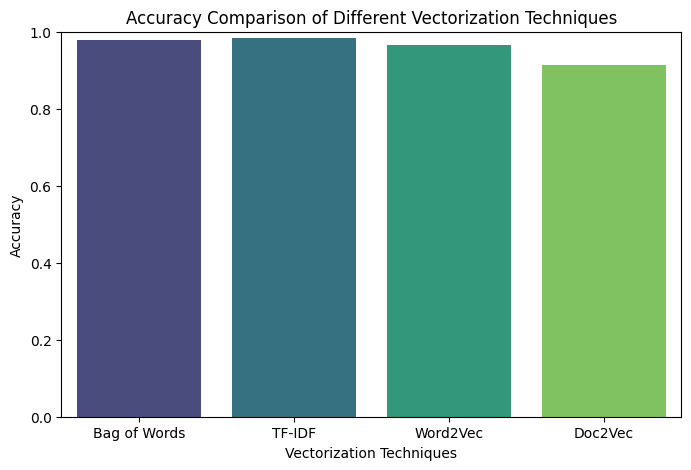

In [10]:
# Comparaison des scores d'accuracy
accuracies = []

# Modifier train_evaluate pour sauvegarder les accuracy
def train_evaluate_with_accuracy(X, y, vectorization_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((vectorization_name, acc))
    print(f"{vectorization_name} Accuracy: {acc:.2f}")

# Appeler cette fonction pour chaque modèle
train_evaluate_with_accuracy(X_bow, y, "Bag of Words")
train_evaluate_with_accuracy(X_tfidf, y, "TF-IDF")
train_evaluate_with_accuracy(X_w2v, y, "Word2Vec")
train_evaluate_with_accuracy(X_doc2vec, y, "Doc2Vec")

# Afficher les scores en barres
vectorization_names, scores = zip(*accuracies)

plt.figure(figsize=(8, 5))
sns.barplot(x=vectorization_names, y=scores, palette="viridis")
plt.title("Accuracy Comparison of Different Vectorization Techniques")
plt.ylabel("Accuracy")
plt.xlabel("Vectorization Techniques")
plt.ylim(0, 1)
plt.show()


--- Bag of Words ---
Accuracy: 0.9797101449275363
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.95      0.98      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



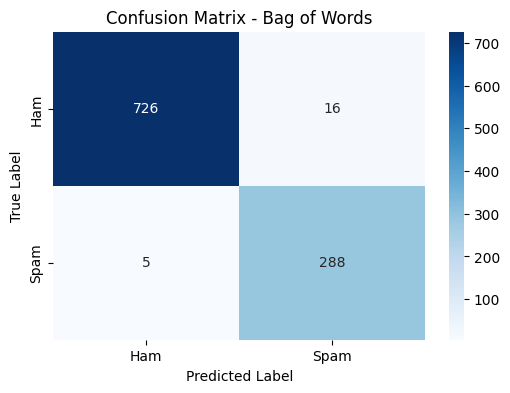

--- TF-IDF ---
Accuracy: 0.9845410628019323
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035



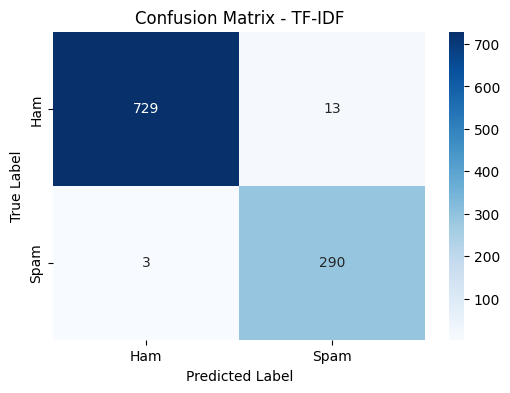

--- Word2Vec ---
Accuracy: 0.9642512077294686
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       742
           1       0.92      0.96      0.94       293

    accuracy                           0.96      1035
   macro avg       0.95      0.96      0.96      1035
weighted avg       0.97      0.96      0.96      1035



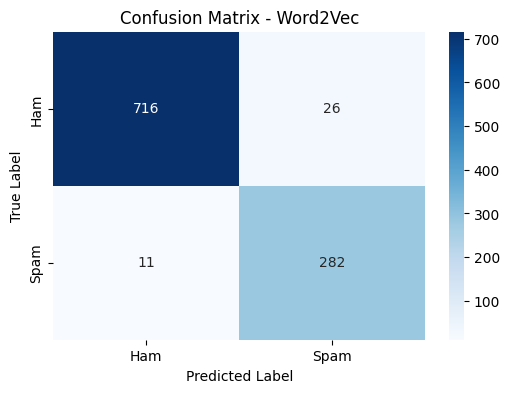

--- Doc2Vec ---
Accuracy: 0.9140096618357488
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       742
           1       0.93      0.76      0.83       293

    accuracy                           0.91      1035
   macro avg       0.92      0.87      0.89      1035
weighted avg       0.91      0.91      0.91      1035



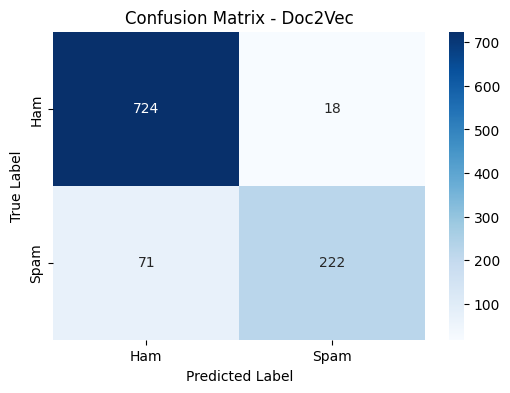

In [11]:
# Évaluer chaque technique
train_evaluate(X_bow, y, "Bag of Words")
train_evaluate(X_tfidf, y, "TF-IDF")
train_evaluate(X_w2v, y, "Word2Vec")
train_evaluate(X_doc2vec, y, "Doc2Vec")

combiner les techniques de vectorisation pour creer des representations hybrides

ajouter des caracteristiques supplementaires comme la largeur des messages ou la frequence des mots specifiques au spam

ajouter de la regularisation

essayer des modeles qui capturent les dependances syntaxiques grammaticales dans le texte

utiliser glove pour la representation vectorielle